In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, ParameterGrid, KFold
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.7.0'

### MLP module

In [3]:
class MLP(object):
    def __init__(self, input_size, output_size, hidden_size=256, device=None):
        """
        input_size: int, size of input layer
        output_size: int, size of output layer
        hidden_size: int, size of hidden layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Execution
        """
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.device = device
 
        # Initialize weights for input layer
        self.W1 = tf.Variable(tf.random.normal([self.input_size, self.hidden_size]))
        self.b1 = tf.Variable(tf.random.normal([1, self.hidden_size]))

        # Initialize weights for the first hidden layer
        self.W12 = tf.Variable(tf.random.normal([self.hidden_size, self.hidden_size]))
        self.b12 = tf.Variable(tf.random.normal([1, self.hidden_size]))

        # Initialize weights between the first hidden layer and the second hidden layer
        self.W22 = tf.Variable(tf.random.normal([self.hidden_size, self.hidden_size]))
        self.b22 = tf.Variable(tf.random.normal([1, self.hidden_size]))

        # Initialize weights between the second hidden layer and the output layer
        self.W2 = tf.Variable(tf.random.normal([self.hidden_size, self.output_size]))
        self.b2 = tf.Variable(tf.random.normal([1, self.output_size]))

        # define variables to be updated during backpropagation
        self.variables = [self.W1, self.W12, self.W22, self.W2, self.b1, self.b12, self.b22, self.b2]

    
    def forward(self, X, dropout=0.0):
        """ Forward pass
        X: tensor, inputs
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = self.compute_output(X, dropout)
        else:
            self.y = self.compute_output(X, dropout)
        
        return self.y
    
    def loss(self, y_pred, y_true, beta=0.0):
        """
        y_pred: tensor of shape (batch_size, output_size),
        y_true: tensor of shape (batch_size), true labels are provided as integers
        beta: weight of penalty term
        """
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        y_true_tf = tf.cast(y_true, dtype=tf.int32)
        cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_tf, logits=y_pred_tf))
        l2_penalty = tf.nn.l2_loss(self.W1) + tf.nn.l2_loss(self.W12) + tf.nn.l2_loss(self.W2)
        total_cost = cost + beta * l2_penalty

        return total_cost
    
    def backward(self, X_train, y_train, dropout=0.0, beta=0.0, lr=1e-6):
        """
        backward pass
        X_train: tensor of shape (batch_size, input_size)
        y_train: tensor of shape (batch_size)
        dropout:
        beta:
        lr:
        """
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

        with tf.GradientTape() as tape:
            predicted = self.forward(X_train, dropout=dropout)
            current_loss = self.loss(predicted, y_train,beta=beta)
        grads = tape.gradient(current_loss, self.variables)
        optimizer.apply_gradients(zip(grads, self.variables))

        return predicted, current_loss, grads
    
    def compute_output(self, X, dropout):
        """Custom method to obtain output tensor during forward pass
        X: tensor, input
        dropout: dropout rate
        """

        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)

        # compute values in the input layer
        logits1 = tf.matmul(X_tf, self.W1) + self.b1
        input_layer = tf.nn.relu(logits1)

        # compute values in the first hidden layer
        logits12 = tf.matmul(input_layer, self.W12) + self.b12
        hidden_layer1 = tf.nn.relu(logits12)
        # hidden_layer1_dropout = tf.nn.dropout(hidden_layer1, rate=dropout_rate, seed=1)
        hidden_layer1_dropout = tf.nn.experimental.stateless_dropout(hidden_layer1, rate=dropout, seed=[0,1])

        # compute values in the second hidden layer
        logits22 = tf.matmul(hidden_layer1_dropout, self.W22) + self.b22
        hidden_layer2 = tf.nn.relu(logits22)
        # hidden_layer2_dropout = tf.nn.dropout(hidden_layer2, rate = dropout_rate, seed = 2)
        hidden_layer2_dropout = tf.nn.experimental.stateless_dropout(hidden_layer2, rate=dropout, seed=[1,2])

        # compute values in the output layer
        output = tf.matmul(hidden_layer2_dropout, self.W2) + self.b2
        return output


In [4]:
def load_data(dataset='fashion_mnist', valid_size=0.2):
    if dataset == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    elif dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    else:
        print("invalid dataset")
        return
   
    # scale data to the range of [0,1]
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    x_train_tf = tf.reshape(x_train, (x_train.shape[0], -1))
    x_test_tf = tf.reshape(x_test, (x_test.shape[0], -1))
    
    return x_train_tf, y_train, x_test_tf, y_test


def accuracy(predictions, labels):
    preds = tf.argmax(predictions, axis=1).numpy()
    acc = np.sum(preds == labels) / predictions.shape[0]
    return 100.0* acc


def train(model, x_train_tf, y_train, x_validation_tf, y_validation, 
          batch_size=32, 
          dropout_rate=0.0, 
          beta=0.0, 
          learning_rate=1e-5, 
          epochs=10):
    
    epoch = 0
    global_step = 0
    eval_steps = 100
    train_data_size, validation_data_size = x_train_tf.shape[0], x_validation_tf.shape[0]

    train_losses = []
    eval_losses = []
    train_accuracy = []
    eval_accuracy = []

    while epoch < epochs:
        epoch += 1
        # Split dataset into batches
        train_ds = tf.data.Dataset.from_tensor_slices((x_train_tf, y_train)).shuffle(train_data_size, 
                                                                                 seed=epoch*(1234)).batch(batch_size)
        
        for inputs, outputs in train_ds:
            train_preds, train_loss, _ = model.backward(inputs, outputs, dropout=dropout_rate, lr=learning_rate, beta=beta)

            global_step += 1
            if global_step % eval_steps == 0:
                train_losses.append(train_loss)
                train_acc = accuracy(tf.nn.softmax(train_preds), outputs)
                train_accuracy.append(train_acc)

                # evaluation
                eval_preds = model.forward(x_validation_tf, dropout=0.0)
                eval_loss = model.loss(eval_preds, y_validation, beta=0.0)
                eval_acc = accuracy(tf.nn.softmax(eval_preds), y_validation)
                
                eval_losses.append(eval_loss)
                eval_accuracy.append(eval_acc)
                print('Epoch={}, Steps={} - Average Train Loss:={}, Average Evaluation Loss:={}, Train Batch Acc:={}, Evaluation Acc:={}'.format(epoch, global_step, train_loss, eval_loss, train_acc, eval_acc))
    
    return model, train_losses, eval_losses, train_accuracy, eval_accuracy

def test(model, x_test_tf, y_test):
    test_preds = model.forward(x_test_tf, dropout=0.0)
    test_acc = accuracy(tf.nn.softmax(test_preds), y_test)
    return test_acc


### visualize data samples

11501568/11490434 [==============================] - 0s 0us/step
sample image shape: (28, 28)
sample image label: 5


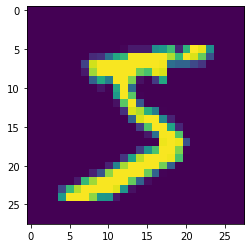

In [5]:
train_x, train_y, test_x, test_y = load_data(dataset="mnist")
sample = tf.reshape(train_x[0], (28,28))
print(f"sample image shape: {sample.shape}")
print(f"sample image label: {train_y[0]}")
plt.imshow(sample)

### Model1: without any regularization

#### obtain a baseline accuracy with default hyperparameters configuration.

In [ ]:
image_size = 28
input_size = image_size * image_size
output_size = 10

x_train, y_train, x_test, y_test = load_data(dataset="mnist")
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

baseline_mlp = MLP(input_size, output_size)
baseline_mlp, train_losses, eval_losses, train_accuracy, eval_accuracy = train(baseline_mlp, x_train, y_train, x_test, y_test)

x_train shape: (60000, 784)
x_test shape: (10000, 784)
Epoch=1, Steps=100 - Average Train Loss:=7743.23095703125, Average Evaluation Loss:=6305.08056640625, Train Batch Acc:=9.375, Evaluation Acc:=17.4
Epoch=1, Steps=200 - Average Train Loss:=4408.05859375, Average Evaluation Loss:=4368.32763671875, Train Batch Acc:=28.125, Evaluation Acc:=30.11
Epoch=1, Steps=300 - Average Train Loss:=3413.2265625, Average Evaluation Loss:=3452.770751953125, Train Batch Acc:=31.25, Evaluation Acc:=38.91
Epoch=1, Steps=400 - Average Train Loss:=2766.834716796875, Average Evaluation Loss:=2879.691650390625, Train Batch Acc:=59.375, Evaluation Acc:=45.26
Epoch=1, Steps=500 - Average Train Loss:=4571.1962890625, Average Evaluation Loss:=2501.359375, Train Batch Acc:=25.0, Evaluation Acc:=50.19
Epoch=1, Steps=600 - Average Train Loss:=2802.1611328125, Average Evaluation Loss:=2230.286865234375, Train Batch Acc:=46.875, Evaluation Acc:=53.779999999999994
Epoch=1, Steps=700 - Average Train Loss:=1556.9201660

baseline test accuracy

In [ ]:
baseline_accuracy = test(baseline_mlp, x_test, y_test)
print(baseline_accuracy)

86.83999999999999


learning curve

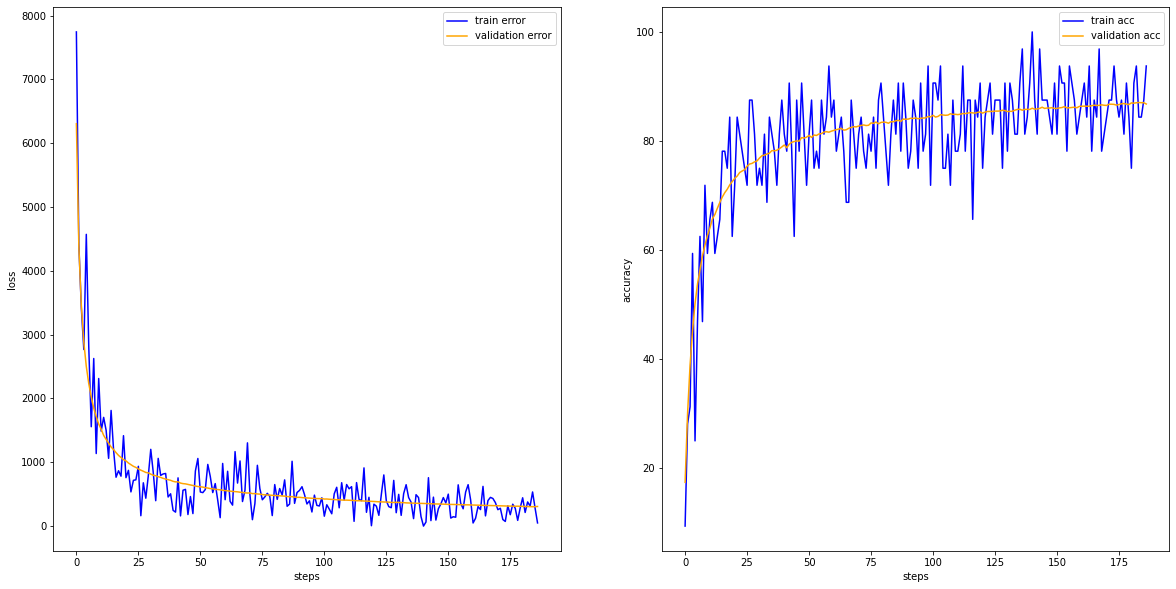

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].plot(train_losses, label="train error", color='blue')
axs[0].plot(eval_losses, label="validation error", color='orange')
axs[0].set_xlabel("steps")
axs[0].set_ylabel("loss")
axs[0].legend(loc="upper right")

axs[1].plot(train_accuracy, label="train acc", color="blue")
axs[1].plot(eval_accuracy, label="validation acc", color='orange')
axs[1].set_xlabel("steps")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper right")

plt.show()

#### hyperparameter tuning

In [6]:
input_size = 28 * 28
output_size = 10

hidden_size = [256, 512]
learning_rate = [1e-4, 1e-5]
batch_size = [32, 128]
epochs = [5, 10]

grid = dict(
    hidden_size = hidden_size,
    learning_rate = learning_rate,
    batch_size = batch_size,
    epochs = epochs
)

x_train_tf, y_train_tf, x_test_tf, y_test_tf = load_data(dataset='mnist')

print("performing grid search...")
params_grid = list(ParameterGrid(grid))

test_accuracy = []
for params in params_grid:
    print(f"current parameters: {params}")
    kf = KFold(n_splits=5, random_state=12, shuffle=True)
    acc = []

    for train_index, validation_index in kf.split(x_train_tf):
        train_indices = np.reshape(train_index, (len(train_index), -1))
        validation_indices = np.reshape(validation_index, (len(validation_index), -1))

        x_train = tf.gather_nd(x_train_tf, indices=train_indices)
        x_validation = tf.gather_nd(x_train_tf, indices=validation_indices)

        y_train, y_validation = y_train_tf[train_index], y_train_tf[validation_index]

        print(f"x_train shape: {x_train.shape}")
        print(f"x_validation shape: {x_validation.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"y_validation shape: {y_validation.shape}")


        mlp = MLP(input_size, output_size, params['hidden_size'])
        mlp, _, _, _, _ = train(mlp, x_train, y_train, x_validation, y_validation,
                    batch_size = params['batch_size'], 
                    learning_rate = params['learning_rate'], 
                    epochs = params['epochs'])
        _acc = test(mlp, x_validation, y_validation)
        acc.append(_acc)
    
    test_accuracy.append(np.mean(acc))

pos = test_accuracy.index(max(test_accuracy))
best_params = params_grid[pos]
print(f"best parameters: {best_params}")


Streaming output truncated to the last 5000 lines.
Epoch=5, Steps=6200 - Average Train Loss:=199.7725067138672, Average Evaluation Loss:=455.3937072753906, Train Batch Acc:=90.625, Evaluation Acc:=92.80833333333334
Epoch=5, Steps=6300 - Average Train Loss:=0.0, Average Evaluation Loss:=426.80859375, Train Batch Acc:=100.0, Evaluation Acc:=92.98333333333333
Epoch=5, Steps=6400 - Average Train Loss:=0.0, Average Evaluation Loss:=430.83221435546875, Train Batch Acc:=100.0, Evaluation Acc:=92.70833333333334
Epoch=5, Steps=6500 - Average Train Loss:=63.00269317626953, Average Evaluation Loss:=453.7571716308594, Train Batch Acc:=93.75, Evaluation Acc:=92.55833333333334
Epoch=5, Steps=6600 - Average Train Loss:=0.0, Average Evaluation Loss:=431.1669921875, Train Batch Acc:=100.0, Evaluation Acc:=92.925
Epoch=5, Steps=6700 - Average Train Loss:=0.0, Average Evaluation Loss:=438.6472473144531, Train Batch Acc:=100.0, Evaluation Acc:=93.0
Epoch=5, Steps=6800 - Average Train Loss:=0.0, Average Ev

use best parameters to train model and then test

In [8]:
mlp = MLP(input_size, output_size, best_params['hidden_size'])
mlp, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = best_params['batch_size'], 
            learning_rate = best_params['learning_rate'], 
            epochs = best_params['epochs'])

test_acc = test(mlp, x_test_tf, y_test_tf)
print(f"with best parameters, the test accuracy={test_acc}")

Epoch=1, Steps=100 - Average Train Loss:=5519.51953125, Average Evaluation Loss:=3441.528076171875, Train Batch Acc:=65.625, Evaluation Acc:=77.69
Epoch=1, Steps=200 - Average Train Loss:=3240.18896484375, Average Evaluation Loss:=2108.6787109375, Train Batch Acc:=75.0, Evaluation Acc:=84.23
Epoch=1, Steps=300 - Average Train Loss:=388.74005126953125, Average Evaluation Loss:=1959.725341796875, Train Batch Acc:=93.75, Evaluation Acc:=84.59
Epoch=1, Steps=400 - Average Train Loss:=2574.72705078125, Average Evaluation Loss:=1569.92333984375, Train Batch Acc:=84.375, Evaluation Acc:=86.79
Epoch=1, Steps=500 - Average Train Loss:=775.8067016601562, Average Evaluation Loss:=1652.907958984375, Train Batch Acc:=87.5, Evaluation Acc:=85.71
Epoch=1, Steps=600 - Average Train Loss:=2867.2958984375, Average Evaluation Loss:=1416.3231201171875, Train Batch Acc:=78.125, Evaluation Acc:=86.8
Epoch=1, Steps=700 - Average Train Loss:=1262.3828125, Average Evaluation Loss:=1245.9676513671875, Train Bat

learning curve

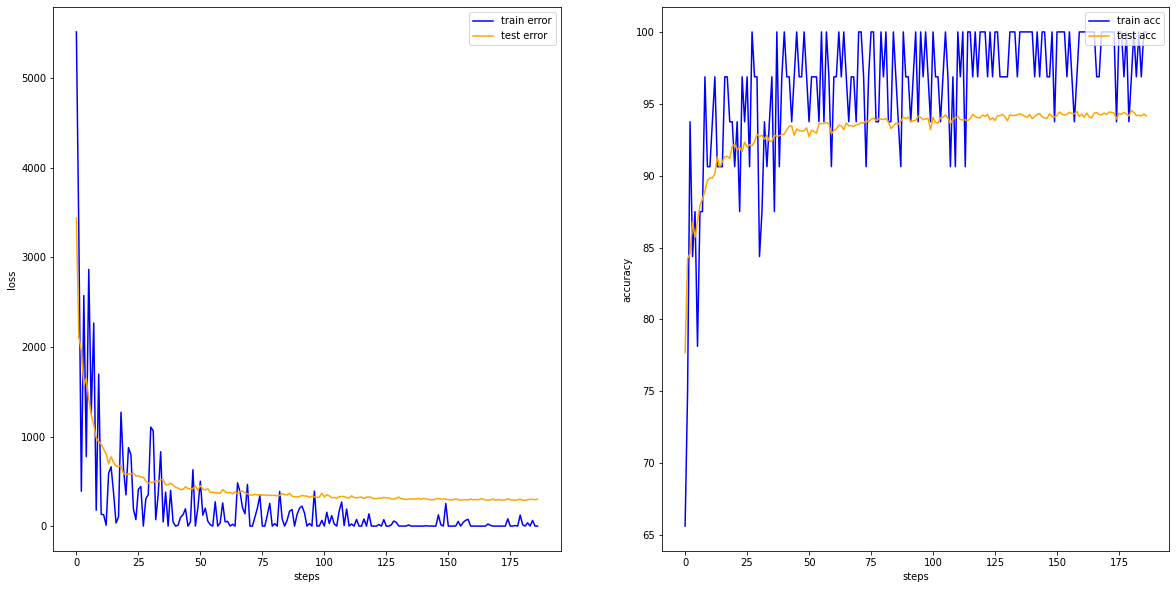

In [10]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].plot(train_losses, label="train error", color='blue')
axs[0].plot(eval_losses, label="test error", color='orange')
axs[0].set_xlabel("steps")
axs[0].set_ylabel("loss")
axs[0].legend(loc="upper right")

axs[1].plot(train_accuracy, label="train acc", color="blue")
axs[1].plot(test_accuracy, label="test acc", color='orange')
axs[1].set_xlabel("steps")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper right")

plt.show()

reporting variance

Epoch=1, Steps=100 - Average Train Loss:=3593.686279296875, Average Evaluation Loss:=3979.232421875, Train Batch Acc:=65.625, Evaluation Acc:=74.59
Epoch=1, Steps=200 - Average Train Loss:=449.70196533203125, Average Evaluation Loss:=2619.4287109375, Train Batch Acc:=84.375, Evaluation Acc:=80.62
Epoch=1, Steps=300 - Average Train Loss:=2711.616455078125, Average Evaluation Loss:=2161.616455078125, Train Batch Acc:=84.375, Evaluation Acc:=82.78999999999999
Epoch=1, Steps=400 - Average Train Loss:=1975.97509765625, Average Evaluation Loss:=1544.9007568359375, Train Batch Acc:=81.25, Evaluation Acc:=86.63
Epoch=1, Steps=500 - Average Train Loss:=684.8355102539062, Average Evaluation Loss:=1318.5384521484375, Train Batch Acc:=93.75, Evaluation Acc:=87.28
Epoch=1, Steps=600 - Average Train Loss:=2920.78662109375, Average Evaluation Loss:=1257.39013671875, Train Batch Acc:=81.25, Evaluation Acc:=88.06
Epoch=1, Steps=700 - Average Train Loss:=1394.4127197265625, Average Evaluation Loss:=1156

{'boxes': [<matplotlib.lines.Line2D at 0x7f07a0bcebd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f07a0bd4c90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f07a0bdbcd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f07a0bdb790>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f07a0bd4210>,
  <matplotlib.lines.Line2D at 0x7f07a0bd4750>]}

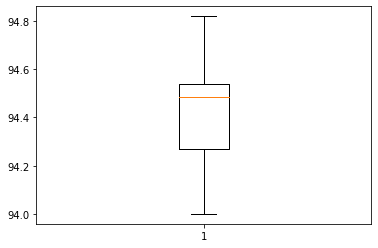

In [11]:
best_params = {
    "hidden_size": 512,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "epochs": 10
}

accuracys = []
for i in range(2, 12):
    tf.random.set_seed(i)

    mlp = MLP(input_size, output_size, best_params['hidden_size'])
    mlp, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = best_params['batch_size'], 
            learning_rate = best_params['learning_rate'], 
            epochs = best_params['epochs'])

    test_acc = test(mlp, x_test_tf, y_test_tf)
    accuracys.append(test_acc)

mean = np.mean(accuracys)
var = np.var(accuracys)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")


{'boxes': [<matplotlib.lines.Line2D at 0x7f07a0bb6310>],
 'caps': [<matplotlib.lines.Line2D at 0x7f07a0bba350>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f07a0bc2390>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f07a0bbae10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f07a0bb6890>,
  <matplotlib.lines.Line2D at 0x7f07a0bb6dd0>]}

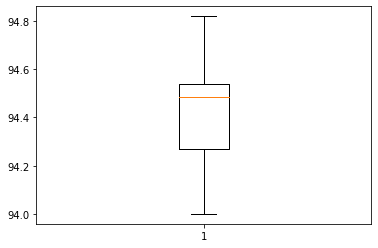

In [12]:
plt.boxplot(accuracys)

### Model2: with dropout regularization

using cross validation to select dropout rate parameter based on previous selected hyperparameters.

In [6]:
input_size = 28 * 28
output_size = 10

hidden_size = 512
learning_rate = 1e-4
batch_size = 32
epochs = 10

dropout_candidates = [0.1, 0.2, 0.3]

x_train_tf, y_train_tf, x_test_tf, y_test_tf = load_data(dataset="mnist")
test_accuracy = []

for dropout in dropout_candidates:
    kf = KFold(n_splits=5, random_state=12, shuffle=True)
    acc = []

    for train_index, validation_index in kf.split(x_train_tf):
        train_indices = np.reshape(train_index, (len(train_index), -1))
        validation_indices = np.reshape(validation_index, (len(validation_index), -1))

        x_train = tf.gather_nd(x_train_tf, indices=train_indices)
        x_validation = tf.gather_nd(x_train_tf, indices=validation_indices)

        y_train, y_validation = y_train_tf[train_index], y_train_tf[validation_index]

        print(f"x_train shape: {x_train.shape}")
        print(f"x_validation shape: {x_validation.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"y_validation shape: {y_validation.shape}")

        mlp = MLP(input_size, output_size, hidden_size)
        mlp, _, _, _, _ = train(mlp, x_train, y_train, x_validation, y_validation,
                    batch_size = batch_size, 
                    learning_rate = learning_rate, 
                    epochs = epochs,
                    dropout_rate = dropout)
        _acc = test(mlp, x_validation, y_validation)
        acc.append(_acc)

    test_accuracy.append(np.mean(acc))
    
pos = test_accuracy.index(max(test_accuracy))
best_dropout = dropout_candidates[pos]
print(f"best dropout rate = {best_dropout}")


x_train shape: (48000, 784)
x_validation shape: (12000, 784)
y_train shape: (48000,)
y_validation shape: (12000,)
Epoch=1, Steps=100 - Average Train Loss:=3731.29443359375, Average Evaluation Loss:=3167.473388671875, Train Batch Acc:=78.125, Evaluation Acc:=80.24166666666666
Epoch=1, Steps=200 - Average Train Loss:=3328.515869140625, Average Evaluation Loss:=2508.21142578125, Train Batch Acc:=81.25, Evaluation Acc:=84.21666666666667
Epoch=1, Steps=300 - Average Train Loss:=4258.7080078125, Average Evaluation Loss:=1937.5933837890625, Train Batch Acc:=75.0, Evaluation Acc:=85.5
Epoch=1, Steps=400 - Average Train Loss:=1451.8759765625, Average Evaluation Loss:=1492.2496337890625, Train Batch Acc:=93.75, Evaluation Acc:=87.825
Epoch=1, Steps=500 - Average Train Loss:=1633.92919921875, Average Evaluation Loss:=1338.9075927734375, Train Batch Acc:=90.625, Evaluation Acc:=88.38333333333334
Epoch=1, Steps=600 - Average Train Loss:=3241.154052734375, Average Evaluation Loss:=1203.38427734375, 

using best parameters to train the model and then test

In [7]:
mlp2 = MLP(input_size, output_size, hidden_size)
mlp2, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp2, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = best_dropout)

test_acc = test(mlp2, x_test_tf, y_test_tf)
print(f"with best dropout rate, the test accuracy={test_acc}")

Epoch=1, Steps=100 - Average Train Loss:=14099.2568359375, Average Evaluation Loss:=3434.801513671875, Train Batch Acc:=46.875, Evaluation Acc:=76.52
Epoch=1, Steps=200 - Average Train Loss:=4331.138671875, Average Evaluation Loss:=2115.052978515625, Train Batch Acc:=65.625, Evaluation Acc:=83.49
Epoch=1, Steps=300 - Average Train Loss:=1968.375244140625, Average Evaluation Loss:=1762.8699951171875, Train Batch Acc:=84.375, Evaluation Acc:=85.66
Epoch=1, Steps=400 - Average Train Loss:=4329.15478515625, Average Evaluation Loss:=1424.7471923828125, Train Batch Acc:=68.75, Evaluation Acc:=87.29
Epoch=1, Steps=500 - Average Train Loss:=4099.9541015625, Average Evaluation Loss:=1446.01171875, Train Batch Acc:=65.625, Evaluation Acc:=87.28
Epoch=1, Steps=600 - Average Train Loss:=3079.123046875, Average Evaluation Loss:=1201.5963134765625, Train Batch Acc:=81.25, Evaluation Acc:=88.4
Epoch=1, Steps=700 - Average Train Loss:=2863.98291015625, Average Evaluation Loss:=1142.388427734375, Train

learning curve

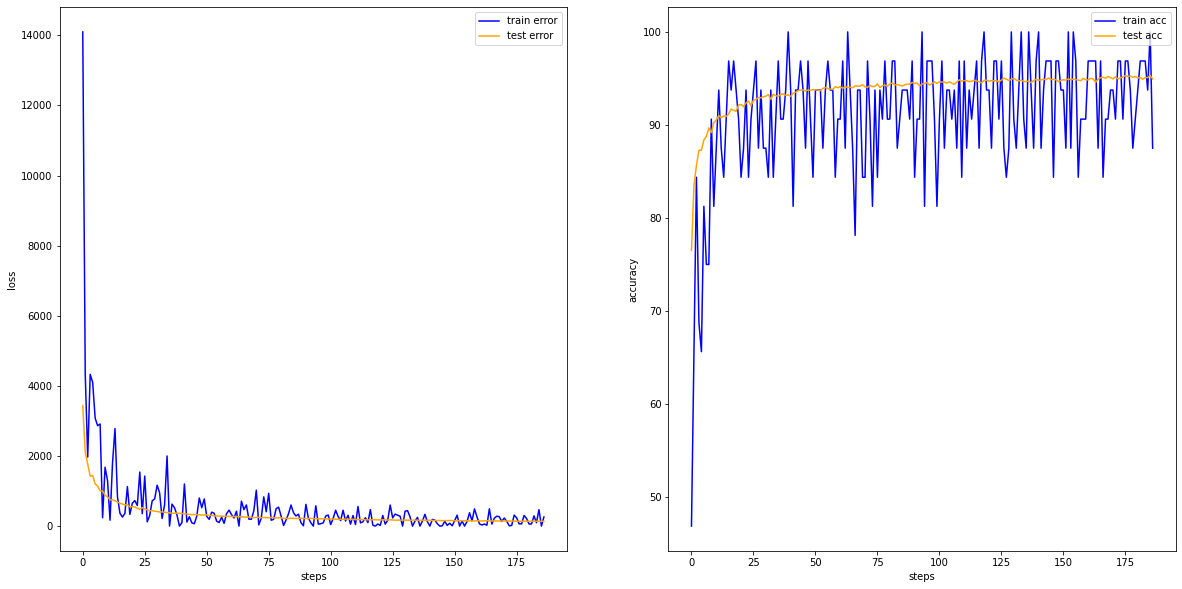

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].plot(train_losses, label="train error", color='blue')
axs[0].plot(eval_losses, label="test error", color='orange')
axs[0].set_xlabel("steps")
axs[0].set_ylabel("loss")
axs[0].legend(loc="upper right")

axs[1].plot(train_accuracy, label="train acc", color="blue")
axs[1].plot(test_accuracy, label="test acc", color='orange')
axs[1].set_xlabel("steps")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper right")

plt.show()

reporting variance

In [9]:
hidden_size = 512
batch_size = 32
learning_rate = 1e-4
epochs = 10
dropout = 0.2

test_accuracys = []
for i in range(4, 14):
    tf.random.set_seed(i)

    mlp = MLP(input_size, output_size, hidden_size)
    mlp, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = dropout)

    test_acc = test(mlp, x_test_tf, y_test_tf)
    test_accuracys.append(test_acc)


Epoch=1, Steps=100 - Average Train Loss:=6079.6435546875, Average Evaluation Loss:=3576.110107421875, Train Batch Acc:=68.75, Evaluation Acc:=79.94
Epoch=1, Steps=200 - Average Train Loss:=7353.595703125, Average Evaluation Loss:=2224.6875, Train Batch Acc:=75.0, Evaluation Acc:=85.32
Epoch=1, Steps=300 - Average Train Loss:=6042.666015625, Average Evaluation Loss:=1749.244384765625, Train Batch Acc:=71.875, Evaluation Acc:=87.33999999999999
Epoch=1, Steps=400 - Average Train Loss:=1595.565673828125, Average Evaluation Loss:=1470.0404052734375, Train Batch Acc:=81.25, Evaluation Acc:=88.51
Epoch=1, Steps=500 - Average Train Loss:=2632.416748046875, Average Evaluation Loss:=1241.6024169921875, Train Batch Acc:=75.0, Evaluation Acc:=89.5
Epoch=1, Steps=600 - Average Train Loss:=1336.1602783203125, Average Evaluation Loss:=1284.2149658203125, Train Batch Acc:=87.5, Evaluation Acc:=89.79
Epoch=1, Steps=700 - Average Train Loss:=917.493408203125, Average Evaluation Loss:=1103.1082763671875,

the mean of 10 runs is 95.402, and the variance is 0.024676000000000572


{'boxes': [<matplotlib.lines.Line2D at 0x7f67e938c0d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f67e9392190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f67e939b1d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f67e9392c50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f67e938c6d0>,
  <matplotlib.lines.Line2D at 0x7f67e938cc10>]}

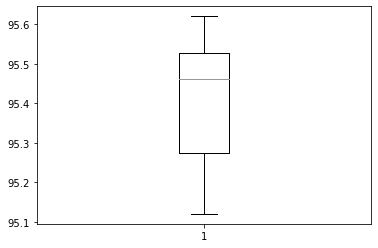

In [10]:
mean = np.mean(test_accuracys)
var = np.var(test_accuracys)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

plt.boxplot(test_accuracys)

### Model3: with dropout and L2 regularization

using cross validation to select beta parameter

In [7]:
input_size = 28 * 28
output_size = 10

hidden_size = 512
batch_size = 32
learning_rate = 1e-4
epochs = 10
dropout = 0.2

beta_candidates = [0.1, 0.01, 0.001]

x_train_tf, y_train_tf, x_test_tf, y_test_tf = load_data(dataset="mnist")
test_accuracy = []

for beta in beta_candidates:
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    acc = []

    for train_index, validation_index in kf.split(x_train_tf):
        train_indices = np.reshape(train_index, (len(train_index), -1))
        validation_indices = np.reshape(validation_index, (len(validation_index), -1))

        x_train = tf.gather_nd(x_train_tf, indices=train_indices)
        x_validation = tf.gather_nd(x_train_tf, indices=validation_indices)

        y_train, y_validation = y_train_tf[train_index], y_train_tf[validation_index]

        print(f"x_train shape: {x_train.shape}")
        print(f"x_validation shape: {x_validation.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"y_validation shape: {y_validation.shape}")
        
        mlp = MLP(input_size, output_size, hidden_size)
        mlp, _, _, _, _ = train(mlp, x_train, y_train, x_validation, y_validation,
                    batch_size = batch_size, 
                    learning_rate = learning_rate, 
                    epochs = epochs,
                    dropout_rate = dropout,
                    beta = beta)
        _acc = test(mlp, x_validation, y_validation)
        acc.append(_acc)

    test_accuracy.append(np.mean(acc))

pos = test_accuracy.index(max(test_accuracy))
best_beta = beta_candidates[pos]
print(f"best beta = {best_beta}")


x_train shape: (48000, 784)
x_validation shape: (12000, 784)
y_train shape: (48000,)
y_validation shape: (12000,)
Epoch=1, Steps=100 - Average Train Loss:=40858.15234375, Average Evaluation Loss:=3382.26123046875, Train Batch Acc:=56.25, Evaluation Acc:=76.575
Epoch=1, Steps=200 - Average Train Loss:=38389.09765625, Average Evaluation Loss:=2145.351318359375, Train Batch Acc:=81.25, Evaluation Acc:=84.35000000000001
Epoch=1, Steps=300 - Average Train Loss:=39565.39453125, Average Evaluation Loss:=1935.7979736328125, Train Batch Acc:=71.875, Evaluation Acc:=84.85000000000001
Epoch=1, Steps=400 - Average Train Loss:=38518.38671875, Average Evaluation Loss:=1492.64404296875, Train Batch Acc:=71.875, Evaluation Acc:=87.05833333333334
Epoch=1, Steps=500 - Average Train Loss:=35951.31640625, Average Evaluation Loss:=1397.8809814453125, Train Batch Acc:=65.625, Evaluation Acc:=87.74166666666666
Epoch=1, Steps=600 - Average Train Loss:=33432.578125, Average Evaluation Loss:=1135.671142578125, 

using the best parameters to train the model and then test

In [10]:
input_size = 28 * 28
output_size = 10

hidden_size = 512
batch_size = 32
learning_rate = 1e-4
epochs = 10
dropout = 0.2

best_beta = 0.01
x_train_tf, y_train_tf, x_test_tf, y_test_tf = load_data(dataset="mnist")


In [12]:
mlp3 = MLP(input_size, output_size, hidden_size)
mlp3, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp3, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = dropout,
            beta = best_beta)

test_acc = test(mlp3, x_test_tf, y_test_tf)
print(f"with best beta, the test accuracy={test_acc}")

with best beta, the test accuracy=95.43


learning curve

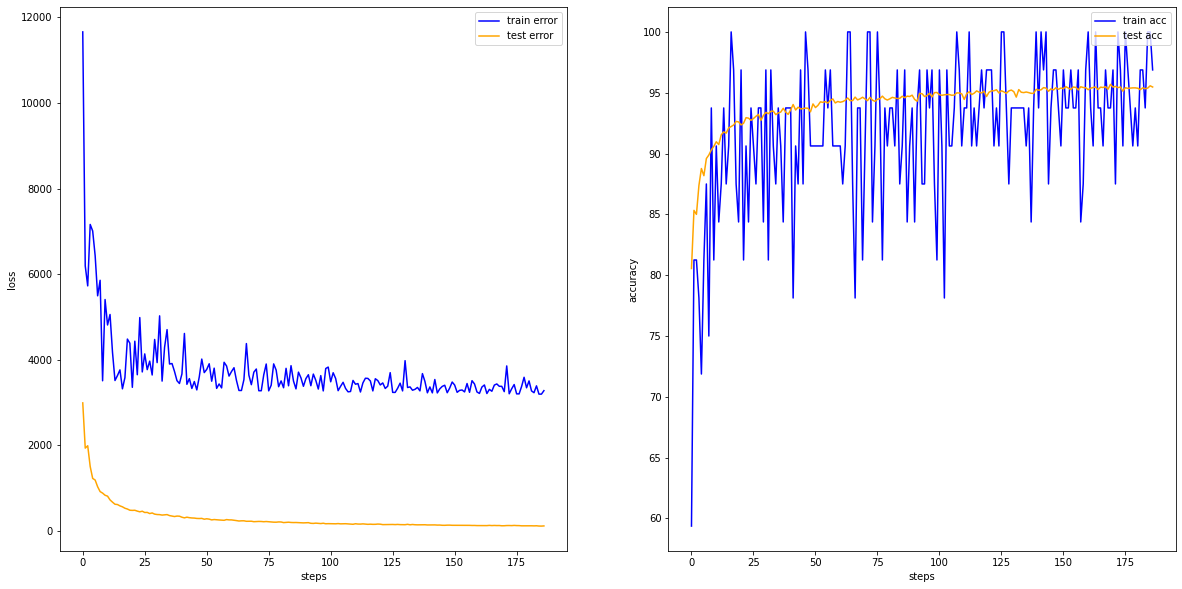

In [13]:
fig, axs = plt.subplots(1,2, figsize=(20, 10))
axs[0].plot(train_losses, label="train error", color='blue')
axs[0].plot(eval_losses, label="test error", color='orange')
axs[0].set_xlabel("steps")
axs[0].set_ylabel("loss")
axs[0].legend(loc="upper right")

axs[1].plot(train_accuracy, label="train acc", color="blue")
axs[1].plot(test_accuracy, label="test acc", color='orange')
axs[1].set_xlabel("steps")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper right")

plt.show()

reporting variance

In [ ]:
hidden_size = 512
batch_size = 32
learning_rate = 1e-4
epochs = 10
dropout = 0.2
beta = 0.01

test_accuracys = []
for i in range(5, 15):
    tf.random.set_seed(i)

    mlp = MLP(input_size, output_size, hidden_size)
    mlp, train_losses, eval_losses, train_accuracy, test_accuracy = train(mlp, x_train_tf, y_train_tf, x_test_tf, y_test_tf,
            batch_size = batch_size, 
            learning_rate = learning_rate, 
            epochs = epochs,
            dropout_rate = dropout,
            beta = beta)

    test_acc = test(mlp, x_test_tf, y_test_tf)
    test_accuracys.append(test_acc)


Epoch=1, Steps=100 - Average Train Loss:=9038.220703125, Average Evaluation Loss:=2719.20068359375, Train Batch Acc:=78.125, Evaluation Acc:=80.78
Epoch=1, Steps=200 - Average Train Loss:=8268.775390625, Average Evaluation Loss:=2096.834716796875, Train Batch Acc:=75.0, Evaluation Acc:=84.23
Epoch=1, Steps=300 - Average Train Loss:=6711.8505859375, Average Evaluation Loss:=1804.7547607421875, Train Batch Acc:=81.25, Evaluation Acc:=85.11999999999999
Epoch=1, Steps=400 - Average Train Loss:=4867.443359375, Average Evaluation Loss:=1370.14208984375, Train Batch Acc:=81.25, Evaluation Acc:=87.45
Epoch=1, Steps=500 - Average Train Loss:=6060.68359375, Average Evaluation Loss:=1177.4443359375, Train Batch Acc:=75.0, Evaluation Acc:=89.08
Epoch=1, Steps=600 - Average Train Loss:=4849.08984375, Average Evaluation Loss:=1067.1016845703125, Train Batch Acc:=87.5, Evaluation Acc:=89.67
Epoch=1, Steps=700 - Average Train Loss:=5166.056640625, Average Evaluation Loss:=1031.697265625, Train Batch A

the mean of 10 runs is 95.27799999999999, and the variance is 0.03455600000000035


{'boxes': [<matplotlib.lines.Line2D at 0x7f2b536b37d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f2b536b9890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2b536be8d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2b536be390>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2b536b3dd0>,
  <matplotlib.lines.Line2D at 0x7f2b536b9350>]}

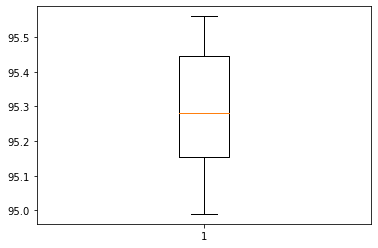

In [ ]:
mean = np.mean(test_accuracys)
var = np.var(test_accuracys)
print(f"the mean of 10 runs is {mean}, and the variance is {var}")

plt.boxplot(test_accuracys)